# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df, df_model
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import least_squares
from typing import Union, Optional
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [17]:
# MODIFIED: Added anchor_slope and anchor_difficulty to the function signature.
def split_params(params: np.ndarray, num_models: int, num_benchmarks: int, anchor_idx: int, model_type: str, anchor_slope: float, anchor_difficulty: float):
    """
    Breaks the flat parameter vector into C, D, full-length α,
    and gammas (for sigmoid_with_offsets).
    """
    C = params[:num_models]

    # MODIFICATION: Reconstruct D by inserting the fixed anchor difficulty.
    # The optimizer only solves for the other N-1 difficulties.
    D_free = params[num_models : num_models + num_benchmarks - 1]
    D = np.insert(D_free, anchor_idx, anchor_difficulty)

    # MODIFICATION: Adjust index for alpha and insert the fixed anchor slope.
    alpha_free = params[num_models + num_benchmarks - 1 : num_models + 2 * num_benchmarks - 2]
    alpha = np.insert(alpha_free, anchor_idx, anchor_slope)

    # Handle parameters specific to the 'sigmoid_with_offsets' model
    if model_type == 'sigmoid_with_offsets':
        # MODIFICATION: Adjust indices for gamma parameters.
        gamma_lower = params[num_models + 2 * num_benchmarks - 2 : num_models + 3 * num_benchmarks - 2]
        gamma_upper = params[num_models + 3 * num_benchmarks - 2:]
        return C, D, alpha, gamma_lower, gamma_upper

    return C, D, alpha

# MODIFIED: Added anchor_slope and anchor_difficulty to the function signature.
def predict(params, model_idx, bench_idx, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty):
    """Calculates predictions based on the specified model type."""
    # Unpack the parameters based on the model type
    # MODIFICATION: Pass anchor values to split_params
    split_args = (params, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty)
    if model_type == 'sigmoid_with_offsets':
        C, D, alpha, lower_asymptote, upper_asymptote = split_params(*split_args)
    else:
        C, D, alpha = split_params(*split_args)

    # Core prediction logic
    x = alpha[bench_idx] * (C[model_idx] - D[bench_idx])

    # Apply the correct functional form
    if model_type == 'clipped_linear':
        return np.clip(x, 0, 1)
    elif model_type == 'sigmoid_with_offsets':
        return lower_asymptote[bench_idx] + (upper_asymptote[bench_idx] - lower_asymptote[bench_idx]) / (1 + np.exp(-x))
    else:  # Default to 'sigmoid'
        return 1.0 / (1.0 + np.exp(-x))

def fit_statistical_model(
    df,
    anchor_benchmark,
    anchor_difficulty,
    anchor_slope,
    slope_init=0.05,
    df_model=None,
    model_type='sigmoid',
    full_dataset_maps=None
):
    """
    Fits a statistical model to benchmark performance data.

    Args:
        df (pd.DataFrame): DataFrame with benchmark performance data.
        anchor_benchmark (str): The name of the anchor benchmark.
        anchor_difficulty (float): The difficulty of the anchor benchmark to be fixed.
        anchor_slope (float): The slope of the anchor benchmark to be fixed.
        slope_init (float, optional): Initial slope value. Defaults to 0.05.
        df_model (pd.DataFrame, optional): DataFrame with model metadata. Defaults to None.
        model_type (str, optional): The type of model to fit.
        full_dataset_maps (dict, optional): Pre-computed mappings for models and benchmarks.
    """
    # ------------------------------------------------------------
    # 1) Mappings & data arrays
    # ------------------------------------------------------------
    if full_dataset_maps:
        model_id_to_idx = full_dataset_maps['model_id_to_idx']
        bench_id_to_idx = full_dataset_maps['bench_id_to_idx']
        valid_model_ids = list(model_id_to_idx.keys())
        benchmark_ids = list(bench_id_to_idx.keys())
    else:
        valid_model_ids = df["model_id"].unique()
        benchmark_ids = df["benchmark_id"].unique()
        model_id_to_idx = {m_id: i for i, m_id in enumerate(valid_model_ids)}
        bench_id_to_idx = {b_id: i for i, b_id in enumerate(benchmark_ids)}

    num_models = len(valid_model_ids)
    num_benchmarks = len(benchmark_ids)

    model_idx_data = np.array([model_id_to_idx[m] for m in df["model_id"]])
    bench_idx_data = np.array([bench_id_to_idx[b] for b in df["benchmark_id"]])
    observed_scores = df["performance"].values

    # ------------------------------------------------------------
    # 2) Anchor benchmark
    # ------------------------------------------------------------
    try:
        anchor_bench_id_from_df = df.loc[df["benchmark"] == anchor_benchmark, "benchmark_id"].iloc[0]
    except IndexError:
        raise ValueError(f"Anchor benchmark “{anchor_benchmark}” not found in the provided dataframe split.")

    anchor_idx = bench_id_to_idx[anchor_bench_id_from_df]

    # ------------------------------------------------------------
    # 3) Residuals function for least squares
    # ------------------------------------------------------------
    def residuals(params, model_idx, bench_idx, y):
        """Calculate the residuals for the least squares fit."""
        # MODIFICATION: Pass anchor values to the predict function.
        preds = predict(params, model_idx, bench_idx, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty)
        return preds - y

    # ------------------------------------------------------------
    # 4) Initial guesses
    # ------------------------------------------------------------
    initial_C = np.zeros(num_models)
    # MODIFICATION: We only optimize N-1 difficulties, since one is fixed.
    initial_D = np.zeros(num_benchmarks - 1)
    initial_alpha = np.full(num_benchmarks - 1, slope_init)
    initial_theta = np.concatenate([initial_C, initial_D, initial_alpha])

    if model_type == 'sigmoid_with_offsets':
        # MODIFICATION: The number of gamma parameters is still num_benchmarks
        initial_gamma_lower = np.full(num_benchmarks, 0.0)
        initial_gamma_upper = np.full(num_benchmarks, 1.0)
        initial_theta = np.concatenate([initial_theta, initial_gamma_lower, initial_gamma_upper])

    # ------------------------------------------------------------
    # 5) Fit
    # ------------------------------------------------------------
    result = least_squares(
        residuals,
        initial_theta,
        args=(model_idx_data, bench_idx_data, observed_scores),
        method="trf",
        verbose=0
    )

    # ------------------------------------------------------------
    # 6) Recover full parameter vectors and normalize
    # ------------------------------------------------------------
    theta_hat = result.x

    # MODIFICATION: Pass anchor values to get the full parameter vectors.
    split_args = (theta_hat, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty)
    if model_type == 'sigmoid_with_offsets':
        C_hat, D_hat, alpha_hat, gammas_hat_lower, gammas_hat_upper = split_params(*split_args)
    else:
        C_hat, D_hat, alpha_hat = split_params(*split_args)

    # MODIFICATION: The normalization shift now correctly centers the capabilities
    # around the fixed anchor difficulty. We no longer need to shift D_hat.
    shift = D_hat[anchor_idx] # This is equal to anchor_difficulty
    C_hat -= shift
    # D_hat -= shift # This line is no longer needed as D is fixed.

    # ------------------------------------------------------------
    # 7) Pack tidy DataFrames for inspection / downstream use
    # ------------------------------------------------------------
    # (This section remains unchanged)
    if df_model is not None:
        id_to_name = df.drop_duplicates("model_id").set_index("model_id")["model"].to_dict()
        model_cap_df = (
            pd.DataFrame({"model_id": valid_model_ids, "estimated_capability": C_hat})
            .assign(model=lambda d: d["model_id"].map(id_to_name))
        )
        model_cap_df = model_cap_df.merge(df_model, on="model", how="left")
        model_capabilities_df = model_cap_df.sort_values("estimated_capability", ascending=False)
    else:
        model_capabilities_df = pd.DataFrame(
            {"model_id": valid_model_ids, "estimated_capability": C_hat}
        ).sort_values("estimated_capability", ascending=False)

    release_date_map = (
        df.drop_duplicates("benchmark_id")
          .set_index("benchmark_id")["benchmark_release_date"]
          .to_dict()
    )

    benchmark_params_df = pd.DataFrame({
        "benchmark_id": benchmark_ids,
        "estimated_difficulty": D_hat,
        "estimated_slope": alpha_hat,
    })

    if model_type == 'sigmoid_with_offsets':
        benchmark_params_df['estimated_lower_asymptote'] = gammas_hat_lower
        benchmark_params_df['estimated_upper_asymptote'] = gammas_hat_upper

    benchmark_params_df = benchmark_params_df.assign(
        benchmark_name=lambda d: d["benchmark_id"].map(
            dict(zip(df["benchmark_id"], df["benchmark"]))
        ),
        benchmark_release_date=lambda d: d["benchmark_id"].map(release_date_map),
    ).sort_values("estimated_difficulty")

    return theta_hat, model_capabilities_df, benchmark_params_df

# ==============================================================================
# NEW MODEL COMPARISON AND CROSS-VALIDATION CODE
# ==============================================================================

def calculate_metrics(y_true, y_pred, num_params):
    """
    Calculates R-squared, MSE, AIC, and BIC.
    """
    n_obs = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    mse = rss / n_obs
    tss = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (rss / tss) if tss > 0 else 0
    aic = n_obs * np.log(mse) + 2 * num_params if mse > 0 else -np.inf
    bic = n_obs * np.log(mse) + num_params * np.log(n_obs) if mse > 0 else -np.inf
    return {'r2': r2, 'mse': mse, 'aic': aic, 'bic': bic}


def compare_models_cross_validation(df, anchor_benchmark, anchor_difficulty, anchor_slope, n_splits=10):
    """
    Compares sigmoid and clipped_linear models using k-fold cross-validation.

    Args:
        df (pd.DataFrame): The full dataset.
        anchor_benchmark (str): The name of the anchor benchmark.
        anchor_difficulty (float): The difficulty value for the anchor benchmark.
        anchor_slope (float): The slope value for the anchor benchmark.
        n_splits (int): The number of folds for cross-validation.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    model_types = ['sigmoid', 'clipped_linear']
    results = []

    # Pre-calculate mappings from the FULL dataset for consistency across folds
    valid_model_ids = df['model_id'].unique()
    benchmark_ids = df['benchmark_id'].unique()
    model_id_to_idx = {m_id: i for i, m_id in enumerate(valid_model_ids)}
    bench_id_to_idx = {b_id: i for i, b_id in enumerate(benchmark_ids)}
    num_models = len(valid_model_ids)
    num_benchmarks = len(benchmark_ids)

    try:
        anchor_bench_id = df.loc[df["benchmark"] == anchor_benchmark, "benchmark_id"].iloc[0]
    except IndexError:
        raise ValueError(f"Anchor benchmark '{anchor_benchmark}' not found in the dataset.")

    anchor_idx = bench_id_to_idx[anchor_bench_id]

    full_dataset_maps = {
        'model_id_to_idx': model_id_to_idx,
        'bench_id_to_idx': bench_id_to_idx,
    }

    print(f"Running {n_splits}-fold cross-validation...")
    for model_type in model_types:
        print(f"  Evaluating model: {model_type}")
        y_pred_out_of_sample = np.zeros(len(df))

        for fold, (train_index, test_index) in enumerate(kf.split(df)):
            # print(f"    - Fold {fold+1}/{n_splits}") # Optional: uncomment for more verbose output
            df_train, df_test = df.iloc[train_index], df.iloc[test_index]

            # --- FIX 1: Pass anchor_difficulty and anchor_slope to the fitting function ---
            theta_hat, _, _ = fit_statistical_model(
                df=df_train,
                anchor_benchmark=anchor_benchmark,
                anchor_difficulty=anchor_difficulty, # Corrected
                anchor_slope=anchor_slope,         # Corrected
                model_type=model_type,
                full_dataset_maps=full_dataset_maps
            )

            # Get indices for the test data using the full dataset mapping
            model_idx_test = np.array([model_id_to_idx[m] for m in df_test["model_id"]])
            bench_idx_test = np.array([bench_id_to_idx[b] for b in df_test["benchmark_id"]])

            # --- FIX 2: Pass anchor_difficulty and anchor_slope to the predict function ---
            y_pred_test = predict(
                theta_hat,
                model_idx_test,
                bench_idx_test,
                num_models,
                num_benchmarks,
                anchor_idx,
                model_type,
                anchor_slope=anchor_slope,         # Corrected
                anchor_difficulty=anchor_difficulty  # Corrected
            )
            y_pred_out_of_sample[test_index] = y_pred_test

        # --- Calculate metrics based on out-of-sample CV predictions ---
        y_true = df['performance'].values
        cv_mse = np.mean((y_true - y_pred_out_of_sample) ** 2)
        cv_tss = np.sum((y_true - np.mean(y_true)) ** 2)
        cv_rss = np.sum((y_true - y_pred_out_of_sample) ** 2)
        cv_r2 = 1 - (cv_rss / cv_tss)

        # --- Fit on full data to get AIC/BIC ---
        print(f"  Fitting {model_type} on full data for AIC/BIC...")
        # --- FIX 3: Use the passed anchor values instead of hardcoded ones ---
        theta_full, _, _ = fit_statistical_model(
            df=df,
            anchor_benchmark=anchor_benchmark,
            anchor_difficulty=anchor_difficulty, # Corrected
            anchor_slope=anchor_slope,         # Corrected
            model_type=model_type
        )

        model_idx_full = np.array([model_id_to_idx[m] for m in df["model_id"]])
        bench_idx_full = np.array([bench_id_to_idx[b] for b in df["benchmark_id"]])

        # --- FIX 4: Pass anchor values to the final predict call ---
        y_pred_full = predict(
            theta_full,
            model_idx_full,
            bench_idx_full,
            num_models,
            num_benchmarks,
            anchor_idx,
            model_type,
            anchor_slope=anchor_slope,         # Corrected
            anchor_difficulty=anchor_difficulty  # Corrected
        )

        num_params = len(theta_full)
        full_data_metrics = calculate_metrics(y_true, y_pred_full, num_params)

        results.append({
            'model_type': model_type,
            'cv_r2': cv_r2,
            'cv_mse': cv_mse,
            'aic': full_data_metrics['aic'],
            'bic': full_data_metrics['bic'],
            'num_params': num_params
        })

    return pd.DataFrame(results)

--- Starting Repetition 1/100 ---
Dropping 7 benchmarks: ['ARC-AGI', 'OTIS Mock AIME 2024-2025', 'GPQA diamond', 'FrontierMath-2025-02-28-Private', 'SimpleBench', 'OpenBookQA', 'CadEval']
Slope for this repetition: 0.3509 capability units / year
----------------------------------------
--- Starting Repetition 2/100 ---
Dropping 7 benchmarks: ['DeepResearch Bench', 'OTIS Mock AIME 2024-2025', 'GSO-Bench', 'Aider polyglot', 'MATH level 5', 'WeirdML', 'GeoBench']
Slope for this repetition: 0.4231 capability units / year
----------------------------------------
--- Starting Repetition 3/100 ---
Dropping 7 benchmarks: ['MMLU', 'GPQA diamond', 'MATH level 5', 'BBH', 'SimpleBench', 'MCBench', 'Terminal Bench']


/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_2225/228722218.py:47: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Slope for this repetition: 0.0986 capability units / year
----------------------------------------
--- Starting Repetition 4/100 ---
Dropping 7 benchmarks: ['Aider polyglot', 'BBH', 'ARC-AGI', 'DeepResearch Bench', 'GeoBench', 'SimpleBench', 'TriviaQA']
Slope for this repetition: 0.4299 capability units / year
----------------------------------------
--- Starting Repetition 5/100 ---
Dropping 7 benchmarks: ['WeirdML', 'FrontierMath-2025-02-28-Private', 'GPQA diamond', 'HellaSwag', 'GeoBench', 'Factorio learning environment', 'Terminal Bench']
Slope for this repetition: 0.4465 capability units / year
----------------------------------------
--- Starting Repetition 6/100 ---
Dropping 7 benchmarks: ['CadEval', 'BBH', 'Factorio learning environment', 'OTIS Mock AIME 2024-2025', 'MATH level 5', 'Balrog', 'ARC-AGI']
Slope for this repetition: 0.3536 capability units / year
----------------------------------------
--- Starting Repetition 7/100 ---
Dropping 7 benchmarks: ['OSWorld', 'DeepResea

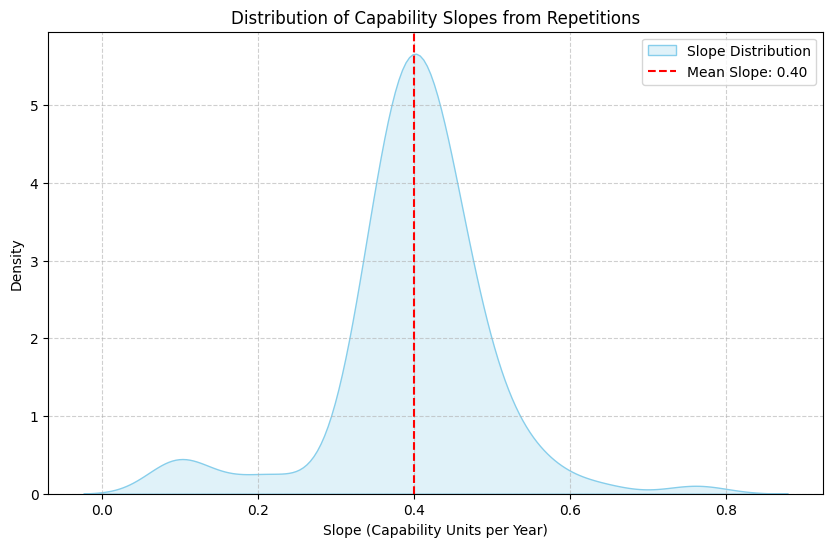

In [18]:
import random
random.seed(42)

def run_analysis():
    # 1. Initial Setup
    n_repetitions = 100
    fraction_to_drop = 0.3
    anchor_benchmark = "Winogrande"
    cutoff_date = pd.Timestamp("2023-01-01")
    slopes_per_repetition = []

    # 2. Main Loop
    for i in range(n_repetitions):
        print(f"--- Starting Repetition {i + 1}/{n_repetitions} ---")

        if scores_df.empty or df_model.empty:
            print("Dataframes `scores_df` or `df_model` not loaded. Halting script.")
            return

        # a. Randomly drop benchmarks
        all_unique_benchmarks = list(scores_df['benchmark'].unique())
        eligible_to_drop = [b for b in all_unique_benchmarks if b != anchor_benchmark]
        num_benchmarks_to_drop = int(len(all_unique_benchmarks) * fraction_to_drop)
        k = min(num_benchmarks_to_drop, len(eligible_to_drop))
        benchmarks_to_drop = random.sample(eligible_to_drop, k=k) if k > 0 else []
        print(f"Dropping {len(benchmarks_to_drop)} benchmarks: {benchmarks_to_drop}")
        scores_df_dropped = scores_df[~scores_df['benchmark'].isin(benchmarks_to_drop)].copy()

        # b. Fit statistical model
        _, df_cm_dropped, _ = fit_statistical_model(scores_df_dropped, anchor_benchmark, 0, 1, df_model=df_model, model_type="sigmoid")

        # c. Prepare data for linear fit
        df_cm_dropped.dropna(subset=['date'], inplace=True)
        if df_cm_dropped.empty:
            print("No models with valid dates remaining. Skipping repetition.")
            print("-" * 40)
            continue

        df_cm_dropped['date_obj'] = pd.to_datetime(df_cm_dropped['date'])
        fit_df = df_cm_dropped[df_cm_dropped['date_obj'] >= cutoff_date].copy()

        # d. Fit linear model
        if len(fit_df) < 2:
            print("Not enough data points after cutoff to fit a line. Skipping repetition.")
            print("-" * 40)
            continue

        dates_num = mdates.date2num(fit_df["date_obj"])
        capabilities = fit_df["estimated_capability"].values.astype(float)
        X = dates_num.reshape(-1, 1)
        y = capabilities
        lin_reg = LinearRegression().fit(X, y)
        slope_per_year = lin_reg.coef_[0] * 365
        slopes_per_repetition.append(slope_per_year)
        print(f"Slope for this repetition: {slope_per_year:.4f} capability units / year")
        print("-" * 40)

    # 3. Final Summary and Plot
    print("\n--- Overall Summary ---")
    if slopes_per_repetition:
        mean_slope = np.mean(slopes_per_repetition)
        std_slope = np.std(slopes_per_repetition)

        print(f"Slopes from {len(slopes_per_repetition)} successful repetitions:")
        print([round(s, 4) for s in slopes_per_repetition])
        print(f"\nAverage slope: {mean_slope:.4f}")
        print(f"Standard deviation of slopes: {std_slope:.4f}")

        # Create the KDE plot
        plt.figure(figsize=(10, 6))
        sns.kdeplot(slopes_per_repetition, fill=True, color='skyblue', label='Slope Distribution')
        plt.axvline(mean_slope, color='red', linestyle='--', label=f'Mean Slope: {mean_slope:.2f}')

        plt.title('Distribution of Capability Slopes from Repetitions')
        plt.xlabel('Slope (Capability Units per Year)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    else:
        print("No slopes were calculated. Check data and cutoff date.")

# Run the entire analysis
run_analysis()

In [19]:
x = [np.float64(0.3617), np.float64(0.5841), np.float64(0.3024), np.float64(0.4446), np.float64(0.3562), np.float64(0.3739), np.float64(0.4184), np.float64(0.3794), np.float64(0.4337), np.float64(0.449), np.float64(0.394), np.float64(0.4795), np.float64(0.5202), np.float64(0.4067), np.float64(0.4123), np.float64(0.3922), np.float64(0.5477), np.float64(0.3888), np.float64(0.3592), np.float64(0.4392), np.float64(0.3802), np.float64(0.392), np.float64(0.3867), np.float64(0.1439), np.float64(0.4399), np.float64(0.4074), np.float64(0.4239), np.float64(0.3364), np.float64(0.1784), np.float64(0.5132), np.float64(0.3938), np.float64(0.3366), np.float64(0.3232), np.float64(0.378), np.float64(0.5379), np.float64(0.3196), np.float64(0.3717), np.float64(0.5414), np.float64(0.3723), np.float64(0.0253), np.float64(0.217), np.float64(0.3863), np.float64(0.4289), np.float64(0.3723), np.float64(0.3782), np.float64(0.3495), np.float64(0.4158), np.float64(0.4857), np.float64(0.3511), np.float64(0.3947), np.float64(0.3725), np.float64(0.5293), np.float64(0.4361), np.float64(0.2887), np.float64(0.1442), np.float64(0.0261), np.float64(0.396), np.float64(0.4045), np.float64(0.4948), np.float64(0.387), np.float64(0.3669), np.float64(0.3909), np.float64(0.4994), np.float64(0.3475), np.float64(0.0352), np.float64(0.4142), np.float64(0.347), np.float64(0.3725), np.float64(0.386), np.float64(0.3551), np.float64(0.4277), np.float64(0.3921), np.float64(0.0384), np.float64(0.3605), np.float64(0.3591), np.float64(0.4534), np.float64(0.4186), np.float64(0.4255), np.float64(0.4325), np.float64(0.4468), np.float64(0.4605), np.float64(0.3465), np.float64(0.3875), np.float64(0.3701), np.float64(0.3722), np.float64(0.3515), np.float64(0.4335), np.float64(0.306), np.float64(0.3214), np.float64(0.4253), np.float64(0.3951), np.float64(0.1564), np.float64(0.3287), np.float64(0.4197), np.float64(0.3883), np.float64(0.3289), np.float64(0.1441), np.float64(0.4601), np.float64(0.3948), np.float64(0.4877)]
np.percentile(x, [5, 50, 95])

array([0.14409 , 0.3879  , 0.520655])